In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns

import itertools as it
import math

# make the graph prettier (seaborn uses matplotlib but with better defaults)
sns.set_style("darkgrid")

In [18]:
def graph_instant(f, step_num, step=True):
    # f is a "math" function mapping from x to y
    x = np.arange(step_num)
    y = list(map(f, x))
    if step:
        plt.step(x, y)
    else:
        plt.plot(x, y)
    
def graph_total(f, step_num):
    x = np.arange(step_num)
    values = list(map(f, x))
    # "integral" of instantaneous values
    y = np.cumsum(values)
    # remove initial value from array
    y = y - y[0]
    plt.plot(x, y)

def adapter(opening_function, f, changeover):
    # returns a function which doesn't adapt until it has been called "enough" 
    opener = it.repeat(opening_function, changeover)
    funcs = it.chain(opener, it.repeat(f))
    def combined(*args, **kwargs):
        return next(funcs)(*args, **kwargs)
        
    return combined

def scenario(base, adapt_time):
    return lambda f: adapter(base, f, adapt_time)

def list_to_func(l):
    # returns a function that generates a list of values
    funcs = ((lambda _: n) for n in l)
    def combined(*args, **kwargs):
        return next(funcs)(*args, **kwargs)
        
    return combined

In [23]:
fred = lambda x: x + 1
joe = lambda x: x + 2

f = adapter(fred, joe, 3)
print(list(range(0, 6)))
[f(x) for x in range(0, 6)]

[0, 1, 2, 3, 4, 5]


[1, 2, 3, 5, 6, 7]

In [3]:
def derived_cost(n):
    # n device inputs
    # device sample rates are tiered at powers of 2
    # adding more inputs decreases the samples per input
    factor = math.ceil(math.log(n, 2))
    cost = (1/2**factor) * n
    return lambda _: cost

base = derived_cost(3)

# the generator for adapted functions for scenario 3
# note that this has to be called each time the function is used
# because calling it spends the adaptation time
cost_3 = scenario(base, 3)

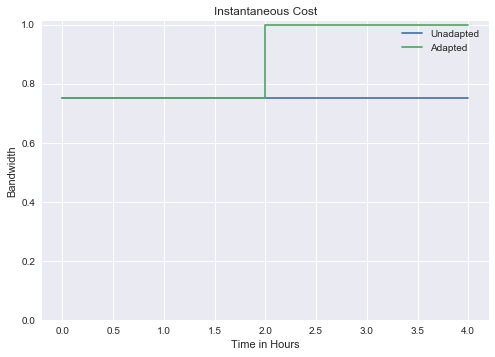

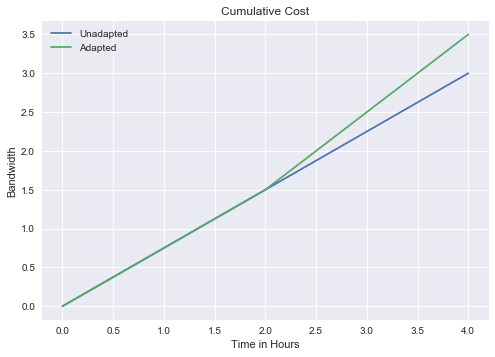

In [4]:
adapted = derived_cost(2)

graph_instant(base, 5)
graph_instant(cost_3(adapted), 5)

# get current axes (to set formatting)
ax = plt.gca()
ax.set_title("Instantaneous Cost")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Bandwidth")
ax.legend(["Unadapted", "Adapted"])
# set y range as necessary
ax.set_ylim(ymin=0)
plt.show()

graph_total(base, 5)
graph_total(cost_3(adapted), 5)

ax = plt.gca()
ax.set_title("Cumulative Cost")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Bandwidth")
ax.legend(["Unadapted", "Adapted"])
plt.show()

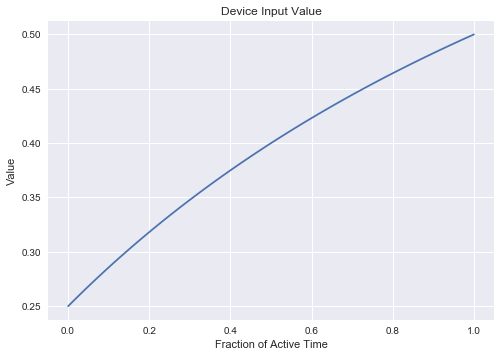

In [5]:
def sensor_value(time_fraction):
    # value of an individual sensor given the fraction of time it is sampling
    # 3 sensors at 1/4 time is full value
    # only meaningful at non-zero sample rates
    return 1 - 3 / (2 * time_fraction + 4)

x = np.linspace(0, 1, 100)
y = sensor_value(x)
plt.plot(x, y)

ax = plt.gca()
ax.set_title("Device Input Value")
ax.set_xlabel("Fraction of Active Time")
ax.set_ylabel("Value")
plt.show()

def device_value(n):
    # n device inputs
    # device sample rate goes up as there are less devices
    # individual device value goes up with higher sample rates
    factor = math.ceil(math.log(n, 2))
    active_time = (1/2**factor)
    return sensor_value(active_time)

# 3 inputs with all 3 on
ideal = lambda _: 3 * device_value(3)
# 3 inputs with only 2 working
broken = lambda _: 2 * device_value(3)
# 2 inputs with both on
adapted = lambda _: 2 * device_value(2)

value_3 = scenario(ideal, 3)

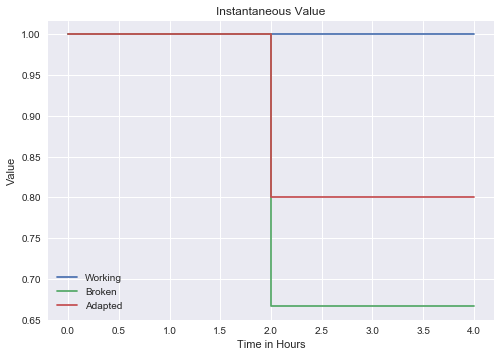

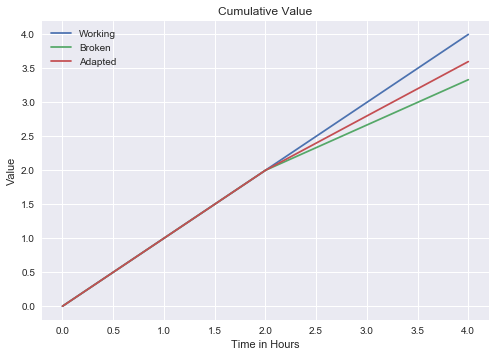

In [6]:
graph_instant(ideal, 5)
graph_instant(value_3(broken), 5)
graph_instant(value_3(adapted), 5)

ax = plt.gca()
ax.set_title("Instantaneous Value")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Value")
ax.legend(["Working", "Broken", "Adapted"])
plt.show()

graph_total(ideal, 5)
graph_total(value_3(broken), 5)
graph_total(value_3(adapted), 5)

ax = plt.gca()
ax.set_title("Cumulative Value")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Value")
ax.legend(["Working", "Broken", "Adapted"])
plt.show()

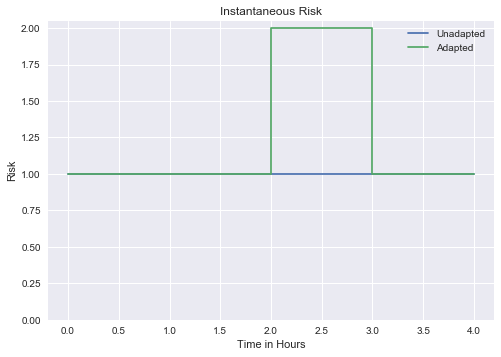

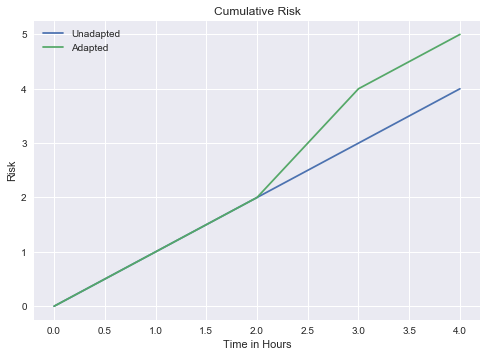

In [7]:
base_risk = lambda _: 1
risk_3 = scenario(base_risk, 3)

# reconfigure changes again after 1 time step
# so just make a new adapter to swap back to base risk after 1 step
reconfigure_risk = adapter(lambda _: 2, base_risk, 1)

graph_instant(base_risk, 5)
graph_instant(risk_3(reconfigure_risk), 5)

ax = plt.gca()
ax.set_title("Instantaneous Risk")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Risk")
ax.legend(["Unadapted", "Adapted"])
ax.set_ylim(ymin=0)
plt.show()

# reload risk function
reconfigure_risk = adapter(lambda _: 2, base_risk, 1)

graph_total(base_risk, 5)
graph_total(risk_3(reconfigure_risk), 5)

ax = plt.gca()
ax.set_title("Cumulative Risk")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Risk")
ax.legend(["Unadapted", "Adapted"])
plt.show()

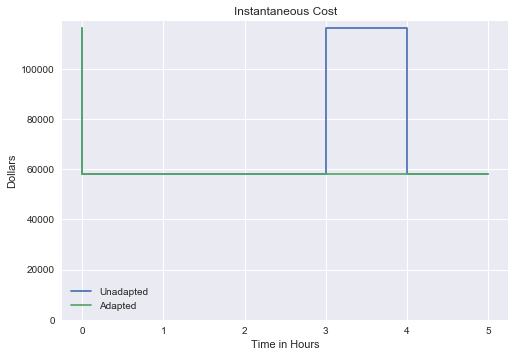

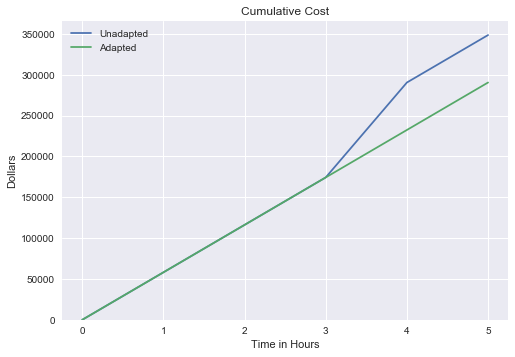

In [8]:
# scenario 1
takeoff = lambda _: 58089 * 2
flight_cost = lambda _: 58059

cost_1 = scenario(takeoff, 1)

# this doesn't work becauseof how I'm offseting the cumsum to line up
# graph_total(cost_1(flight_cost), 7)

x = np.arange(6)
adapted = [58059 * 2] + [58089]*5
unadapted = [58059 * 2] + [58089]*3 + [58089 * 2] + [58089]

graph_instant(list_to_func(unadapted), 6)
graph_instant(list_to_func(adapted), 6)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Instantaneous Cost")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Dollars")
ax.legend(["Unadapted", "Adapted"])
plt.show()

graph_total(list_to_func(unadapted), 6)
graph_total(list_to_func(adapted), 6)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Cumulative Cost")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Dollars")
ax.legend(["Unadapted", "Adapted"])
plt.show()


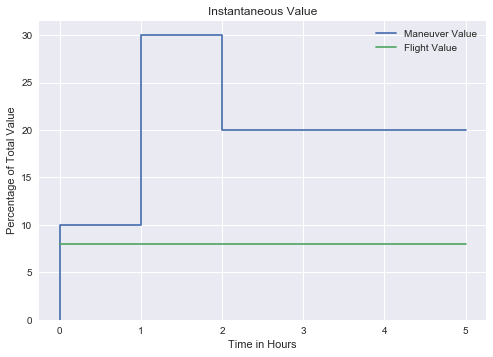

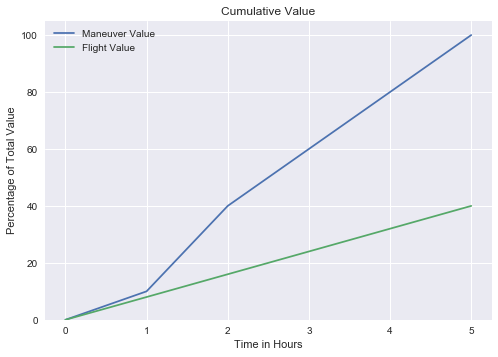

In [9]:
# scenario 1/2 value_1
x = np.arange(6)
step_value = [0, 10, 30, 20, 20, 20]
fly_value =  [8]*6

graph_instant(list_to_func(step_value), 6)
graph_instant(list_to_func(fly_value), 6)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Instantaneous Value")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Percentage of Total Value")
ax.legend(["Maneuver Value", "Flight Value"])
plt.show()

graph_total(list_to_func(step_value), 6)
graph_total(list_to_func(fly_value), 6)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Cumulative Value")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Percentage of Total Value")
ax.legend(["Maneuver Value", "Flight Value"])
plt.show()


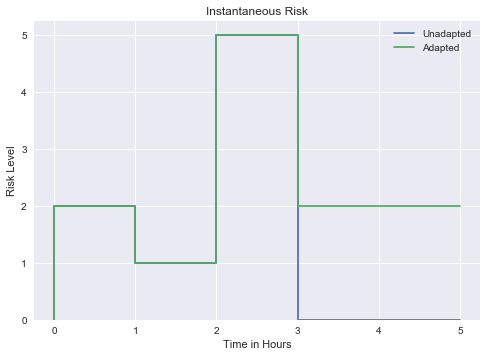

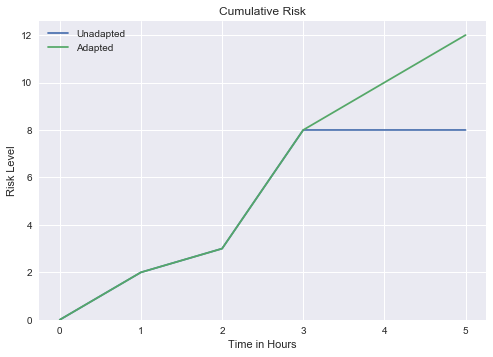

In [10]:
# scenario 1/2 risk 1
x = np.arange(6)
unadapted = [0, 2, 1, 5, 0, 0]
adapted =  [0, 2, 1, 5, 2, 2]

graph_instant(list_to_func(unadapted), 6)
graph_instant(list_to_func(adapted), 6)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Instantaneous Risk")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Risk Level")
ax.legend(["Unadapted", "Adapted"])
plt.show()

graph_total(list_to_func(unadapted), 6)
graph_total(list_to_func(adapted), 6)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Cumulative Risk")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Risk Level")
ax.legend(["Unadapted", "Adapted"])
plt.show()


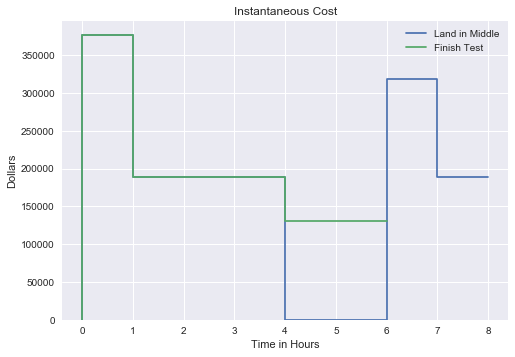

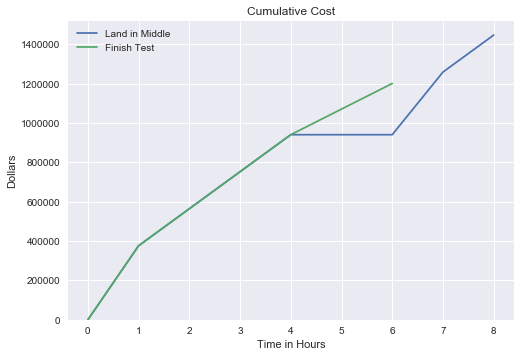

In [11]:
# scenario 4 cost
relay_cost = 58089
ta_cost = 130159

ta_test = [ta_cost*2] + [ta_cost]*5
relay_test = [relay_cost*2] + [relay_cost]*3 + [0]*2

# adapted is takeoff of both plus full runtime of TA
adapted = [0]+list(map(sum, zip(ta_test, relay_test)))
# no telemetry is the same, because the balloon already exists

# land in middle means you stop the TA, then relaunch and finish (also have to pay for relay)
ta_landing = ta_test[:4] + [0]*2 + ta_test[:2]
relay_landing = relay_test + [relay_cost]*2
land_in_middle = [0]+list(map(sum, zip(ta_landing, relay_landing)))

graph_instant(list_to_func(land_in_middle), 9)
graph_instant(list_to_func(adapted), 7)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Instantaneous Cost")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Dollars")
ax.legend(["Land in Middle", "Finish Test"])
plt.show()

graph_total(list_to_func(land_in_middle), 9)
graph_total(list_to_func(adapted), 7)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Cumulative Cost")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Dollars")
ax.legend(["Land in Middle", "Finish Test"])
plt.show()

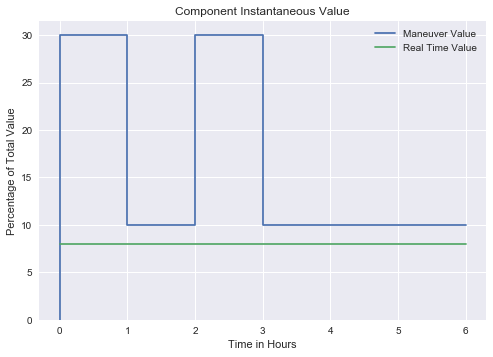

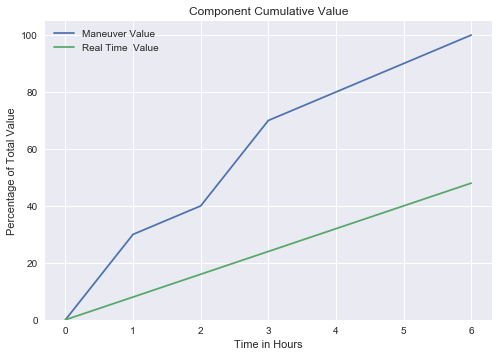

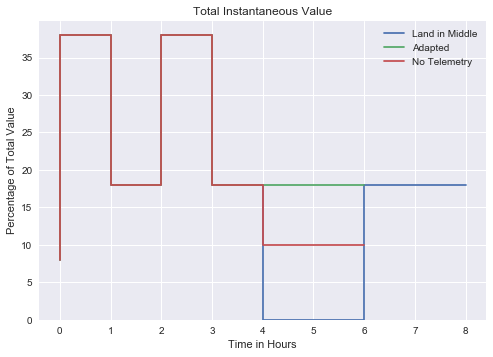

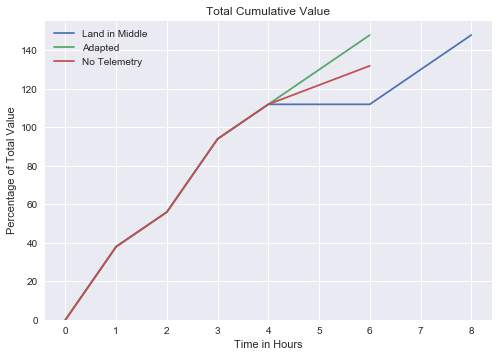

In [12]:
# scenario 4 value
# components
maneuver_value = [0, 30, 10, 30, 10, 10, 10]
real_time_value =  [8]*7

graph_instant(list_to_func(maneuver_value), 7)
graph_instant(list_to_func(real_time_value), 7)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Component Instantaneous Value")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Percentage of Total Value")
ax.legend(["Maneuver Value", "Real Time Value"])
plt.show()

graph_total(list_to_func(maneuver_value), 7)
graph_total(list_to_func(real_time_value), 7)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Component Cumulative Value")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Percentage of Total Value")
ax.legend(["Maneuver Value", "Real Time  Value"])
plt.show()

# combine the components based on the flight plan
adapted = list(map(sum, zip(maneuver_value, real_time_value)))
no_telemetry = list(map(sum, zip(maneuver_value, real_time_value[:5]+[0]*3)))

land_in_middle = list(map(sum, zip(maneuver_value, real_time_value)))
land_in_middle = land_in_middle[:5] + [0]*2 + land_in_middle[5:]

graph_instant(list_to_func(land_in_middle), 9)
graph_instant(list_to_func(adapted), 7)
graph_instant(list_to_func(no_telemetry), 7)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Total Instantaneous Value")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Percentage of Total Value")
ax.legend(["Land in Middle", "Adapted", "No Telemetry"])
plt.show()

graph_total(list_to_func(land_in_middle), 9)
graph_total(list_to_func(adapted), 7)
graph_total(list_to_func(no_telemetry), 7)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Total Cumulative Value")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Percentage of Total Value")
ax.legend(["Land in Middle", "Adapted", "No Telemetry"])
plt.show()

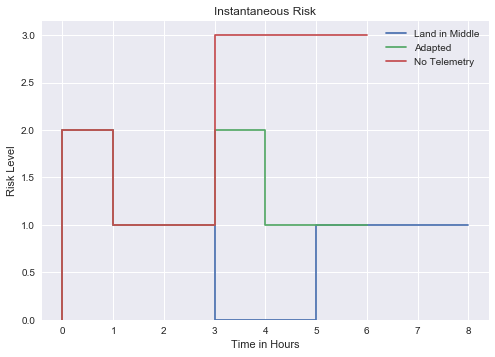

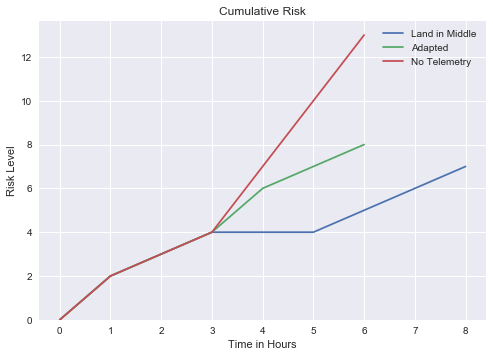

In [13]:
# scenario 4 risk
land_in_middle = [0, 2, 1, 1, 0, 0, 1, 1, 1]
adapted = [0, 2, 1, 1, 2, 1, 1]
no_telemetry =  [0, 2, 1, 1, 3, 3, 3]

graph_instant(list_to_func(land_in_middle), 9)
graph_instant(list_to_func(adapted), 7)
graph_instant(list_to_func(no_telemetry), 7)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Instantaneous Risk")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Risk Level")
ax.legend(["Land in Middle", "Adapted", "No Telemetry"])
plt.show()

graph_total(list_to_func(land_in_middle), 9)
graph_total(list_to_func(adapted), 7)
graph_total(list_to_func(no_telemetry), 7)

ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_title("Cumulative Risk")
ax.set_xlabel("Time in Hours")
ax.set_ylabel("Risk Level")
ax.legend(["Land in Middle", "Adapted", "No Telemetry"])
plt.show()

In [14]:
print(7+5)
"hello"

12


'hello'